In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm


In [2]:
from mpl_toolkits.mplot3d import Axes3D

# Layer and models

In [244]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
#Thsi object can be extended
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.weight = nn.Parameter(torch.Tensor(self.in_dim, self.in_dim, self.in_dim))
    
    def forward(self, x):
        xBx = x.matmul(self.weight).matmul(x.t()).permute(2,1,0)
        out = torch.diagonal(xBx).t()
        return out
    
    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.srqt(5))
        
class LinearODEModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(LinearODEModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NNODEModel, self).__init__()
        #Dimension
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        #Layer 
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim)
        self.nl_ode = NonLinearODELayer(self.in_dim, self.hid_dim, self.out_dim)
        
        #weight init
        self.lin_ode.weight.data.uniform_(-0.1,0.1)
        self.nl_ode.weight.data.uniform_(-0.001,0.001)
            
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out

In [275]:
def train_model(model, train_x, train_y, loss_fn, optimizer, batch_size):
    train_loss = 0
    for b in range(0, train_x.size(0), batch_size):
        model.zero_grad()
        pred = model(train_x.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_y.narrow(0, b, batch_size))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss

# Training Pendulum with Linear ODE Model

In [50]:
kk = 0.01
AA = np.asarray([[1,1],[-kk,1]])

sol = [[0.99,1]]
for i in range(100):
    sol.append(np.dot(np.asarray(sol[-1]),AA))
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([100, 2])
train_y.shape: torch.Size([100, 2])


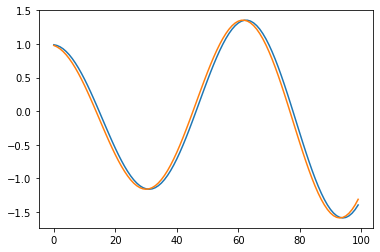

In [57]:
plt.plot(train_x[:,0].numpy());
plt.plot(train_y[:,0].numpy())
plt.show()

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.4557,  0.6042],
        [-0.6894,  0.4489]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9977,  0.9983],
        [-0.0100,  1.0000]], requires_grad=True)]


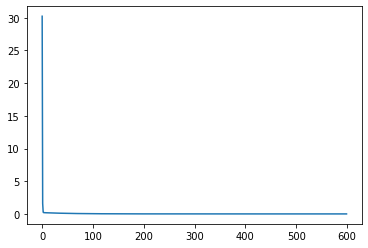

In [7]:
model = LinearODEModel(2, 2)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

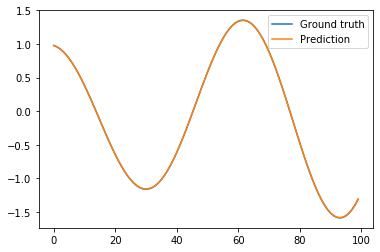

In [12]:
plt.plot(train_y[:,0].numpy(), label='Ground truth')
plt.plot(prediction[:,0].detach().numpy(), label='Prediction')
plt.legend()
plt.show()

# Training pendulum with batches of 10

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[ 0.4757,  0.5248],
        [-0.1768, -0.5596]], requires_grad=True)]
Epoch: 1 train_loss: 102.88022770360112
weight:
[Parameter containing:
tensor([[ 0.5347,  0.6301],
        [-0.0437,  0.9730]], requires_grad=True)]
Epoch: 11 train_loss: 0.3133137070108205
weight:
[Parameter containing:
tensor([[ 0.8438,  0.8759],
        [-0.0213,  0.9910]], requires_grad=True)]
Epoch: 21 train_loss: 0.035281848948216066
weight:
[Parameter containing:
tensor([[ 0.9476,  0.9583],
        [-0.0138,  0.9970]], requires_grad=True)]
Epoch: 31 train_loss: 0.003973013390350388
weight:
[Parameter containing:
tensor([[ 0.9824,  0.9860],
        [-0.0113,  0.9990]], requires_grad=True)]
Epoch: 41 train_loss: 0.00044737051666743355
weight:
[Parameter containing:
tensor([[ 0.9941,  0.9953],
        [-0.0104,  0.9997]], requires_grad=True)]
Epoch: 51 train_loss: 5.0373351314192405e-05
weight:

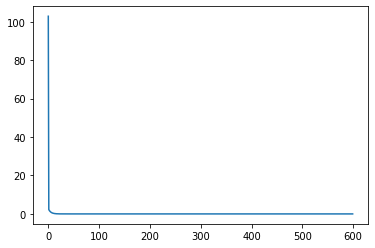

In [63]:
model = LinearODEModel(2, 2)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 10)
    train_loss.append(loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, 'train_loss:', loss)
        print('weight:')
        print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

# Training pendulum with bias

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.6144,  0.5536],
        [ 0.1536, -0.4627]], requires_grad=True), Parameter containing:
tensor([-0.5922,  0.0529], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9899,  0.9979],
        [-0.0098,  1.0000]], requires_grad=True), Parameter containing:
tensor([-0.0072, -0.0008], requires_grad=True)]


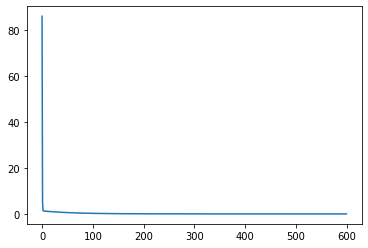

In [109]:
#with bias
model = LinearODEModel(2, 2, True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):  # number of epochs
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()

    # Step 2. Run our forward pass.
    prediction = model(train_x) #minibatches of size 1: to be modified
    # Step 3. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    loss = loss_fn(prediction, train_y)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

Real weigths of the matrix:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0682, -0.3525],
        [-0.5972, -0.5977]], requires_grad=True), Parameter containing:
tensor([ 0.6563, -0.0023], requires_grad=True)]
Epoch: 1 train_loss: 135.5758940577507
weight:
[Parameter containing:
tensor([[ 0.0615, -0.1556],
        [-0.0964,  0.9100]], requires_grad=True), Parameter containing:
tensor([0.6530, 0.1546], requires_grad=True)]
Epoch: 11 train_loss: 2.3525771657004952
weight:
[Parameter containing:
tensor([[ 0.6877,  0.6143],
        [-0.0399,  0.9708]], requires_grad=True), Parameter containing:
tensor([0.2628, 0.0234], requires_grad=True)]
Epoch: 21 train_loss: 0.2898701975354925
weight:
[Parameter containing:
tensor([[ 0.8961,  0.8712],
        [-0.0205,  0.9906]], requires_grad=True), Parameter containing:
tensor([ 0.1085, -0.0052], requires_grad=True)]
Epoch: 31 train_loss: 0.038187254293006845
weight:
[Parameter containing:
tensor([[ 0

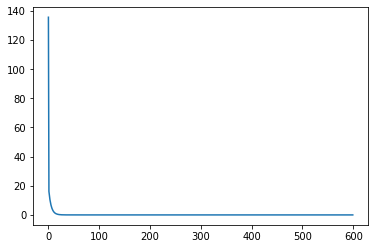

In [64]:
#with bias
model = LinearODEModel(2, 2, True)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Real weigths of the matrix:')
print(AA)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 10)
    train_loss.append(loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, 'train_loss:', loss)
        print('weight:')
        print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

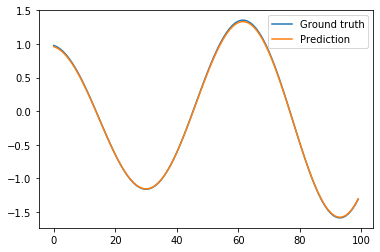

In [110]:
plt.plot(train_y[:,0].numpy(), label='Ground truth')
plt.plot(prediction[:,0].detach().numpy(), label='Prediction')
plt.legend()
plt.show()

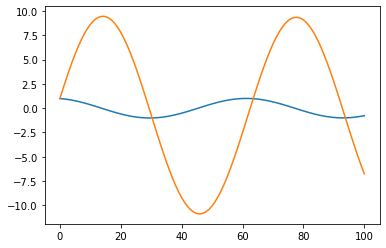

In [128]:
Atest = np.asarray([[0.9899,0.9979],[-0.0098,1.0000]])
btest = np.asarray([-0.0072, -0.0008])

soltest = [[0.99,1]]

for i in range(100):
    soltest.append(np.dot(np.asarray(soltest[-1]),Atest) + btest)
    
Xtest = np.asarray(soltest)
plt.plot(Xtest)
plt.show()

# Training pendulum with Non Linear model

In [153]:
dt = 1
kk = 0.01
A = np.asarray([[0,1],[-kk,0]])

I = np.eye(2)
AA = (I + dt*A)

sol = [[0.99,1]]
for i in range(1000):
    sol.append(np.dot(np.asarray(sol[-1]),AA))
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

Initial matrix A:
[[ 1.    1.  ]
 [-0.01  1.  ]]
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.3252, -0.9440],
        [ 0.2520,  0.8852]], requires_grad=True), Parameter containing:
tensor([[[-0.3817, -0.9234],
         [ 0.5777,  0.3571]],

        [[ 0.4929,  0.0722],
         [ 0.4554,  0.7359]]], requires_grad=True)]
Epoch: 1 train_loss: nan
weight:
[Parameter containing:
tensor([[nan, nan],
        [nan, nan]], requires_grad=True), Parameter containing:
tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], requires_grad=True)]
Epoch: 11 train_loss: nan
weight:
[Parameter containing:
tensor([[nan, nan],
        [nan, nan]], requires_grad=True), Parameter containing:
tensor([[[nan, nan],
         [nan, nan]],

        [[nan, nan],
         [nan, nan]]], requires_grad=True)]
Epoch: 21 train_loss: nan
weight:
[Parameter containing:
tensor([[nan, nan],
        [nan, nan]], requires_grad=True), Parameter containing:
tensor([[[nan, n

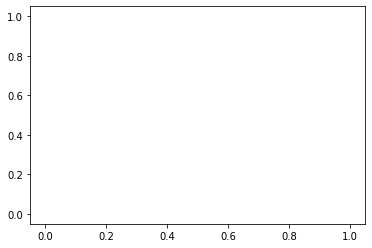

In [154]:
print('Initial matrix A:')
print(AA)


model = NNODEModel(2,2,2,100)
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
print('Initial weigths of the matrix:')
print(list(model.parameters()))

train_loss = []

for epoch in range(600):
    loss = train_model(model, train_x, train_y, loss_fn, optimizer, 20)
    train_loss.append(loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, 'train_loss:', loss)
        print('weight:')
        print(list(model.parameters()))
    
print('Final weigths of the matrix:')
print(list(model.parameters()))
plt.plot(train_loss)
plt.show()

# Training Lorenz attractor with Non Linear ODE model

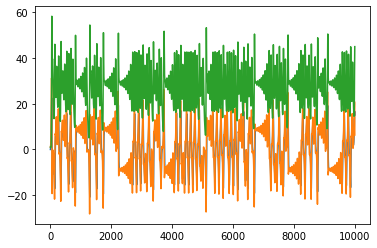

In [39]:
x = 0
y = 1
z = 1.05
sigma = 10
rho = 30
beta = 8/3
dt = 0.01

sol = [[x, y, z]]
for i in range(10000):
    f = x + (sigma*(y - x))*dt
    g = y + (rho*x - x*z - y)*dt
    h = z + (x*y - beta*z)*dt
    sol.append([f,g,h])
    x = f
    y = g
    z = h


plt.plot(sol)
plt.show()

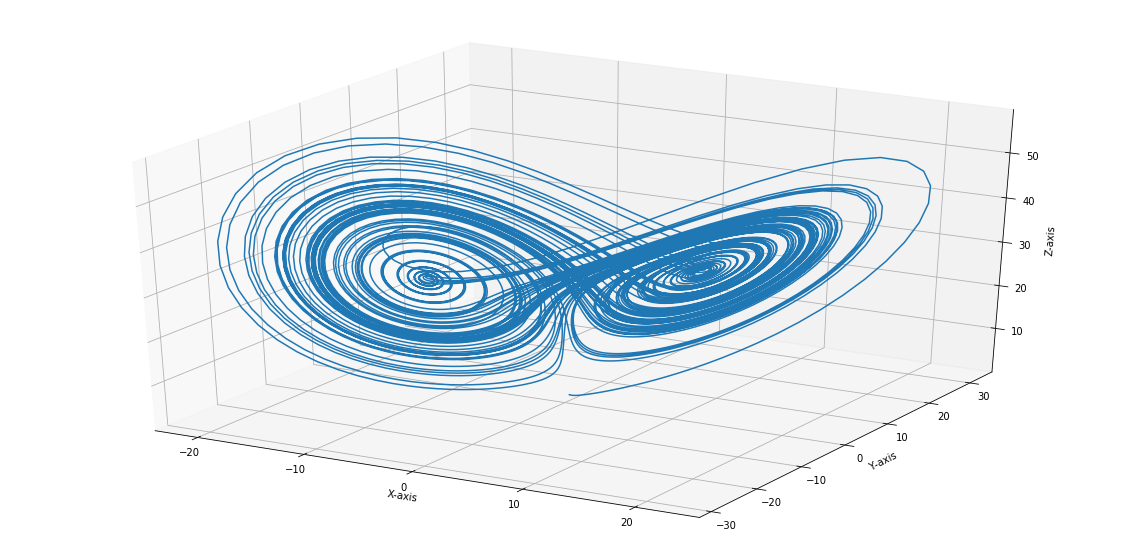

In [57]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(np.array(sol)[:,0], np.array(sol)[:,1], np.array(sol)[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [48]:
sigma = 10
rho = 28
beta = 8/3

dt = 0.01

A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])
Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])
Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])


sol = [[ 0., 1., 1.05]]

for i in range(10000):
    x = np.asarray(sol[-1])
    Ax = A.dot(x)
    
    q0 = x.T.dot(Q0.dot(x))
    q1 = x.T.dot(Q1.dot(x))
    q2 = x.T.dot(Q2.dot(x))

    phix = np.asarray([q0, q1, q2])
    
    f = Ax + phix
    x = x + dt*f
    sol.append(x)
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([10000, 3])
train_y.shape: torch.Size([10000, 3])


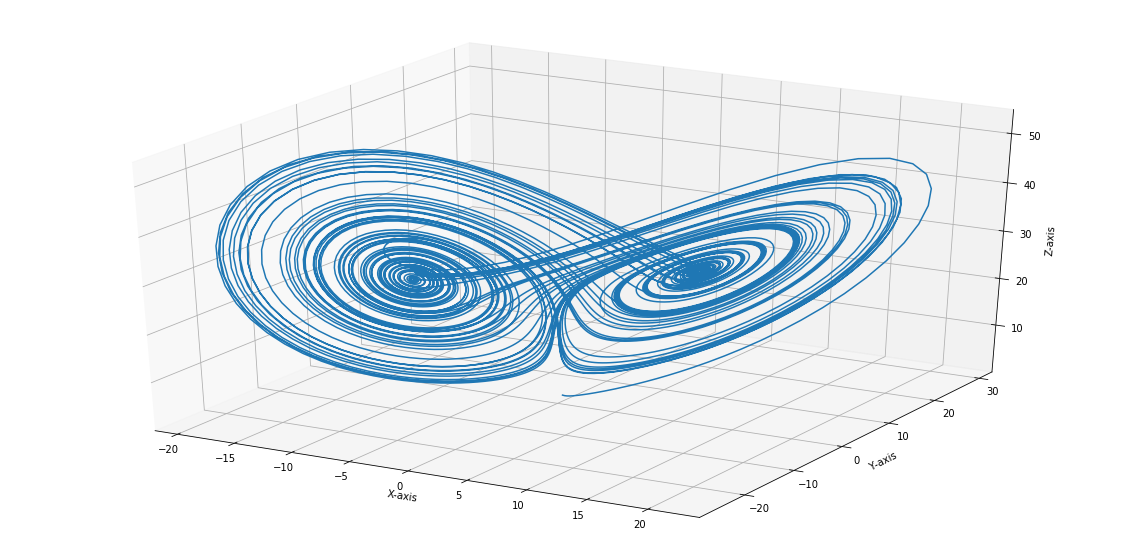

In [72]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [16]:
8/3

2.6666666666666665

In [32]:
#small modification
sigma = 10
rho = 28
beta = 2.67

dt = 0.01

A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])*dt
Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])*dt
Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])*dt

B = np.array([Q0, Q1, Q2])

I = np.eye(3)
AA = (I+dt*A)


sol = [[ 0., 1., 1.05]]

for i in range(10000):
    x = np.asarray(sol[-1])
    Ax = AA.dot(x)
    
    phix = x.T.dot(B).dot(x)
    
    f = Ax + phix
    sol.append(f)
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([10000, 3])
train_y.shape: torch.Size([10000, 3])


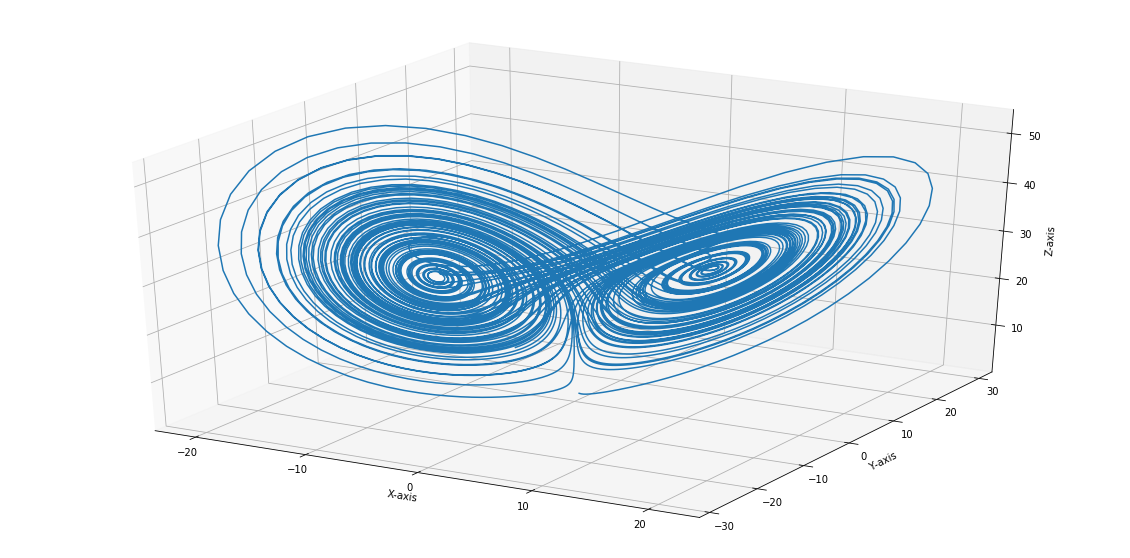

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [44]:
#Testing
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.weight = nn.Parameter(torch.Tensor(B))
    
    def forward(self, x):
        xBx = x.matmul(self.weight).matmul(x.t()).permute(2,1,0)
        out = torch.diagonal(xBx).t()
        return out
    
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(AA))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NNODEModel, self).__init__()
        #Dimension
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        #Layer 
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim)
        self.nl_ode = NonLinearODELayer(self.in_dim, self.hid_dim, self.out_dim)
        
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out

In [20]:
def train_model(model, train_x, train_y, loss_fn, optimizer, batch_size):
    train_loss = 0
    for b in range(0, train_x.size(0), batch_size):
        model.zero_grad()
        pred = model(train_x.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_y.narrow(0, b, batch_size))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss

In [42]:
AA

array([[0.91  , 0.09  , 0.    ],
       [0.28  , 0.99  , 0.    ],
       [0.    , 0.    , 0.9733]])

In [43]:
B

array([[[ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  , -0.01],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]]])

In [36]:
#Training
model = NNODEModel(3,3,3)
list(model.parameters())

[Parameter containing:
 tensor([[0.9000, 0.1000, 0.0000],
         [0.2800, 0.9900, 0.0000],
         [0.0000, 0.0000, 0.9733]], requires_grad=True), Parameter containing:
 tensor([[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0000, -0.0100],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]],
 
         [[ 0.0000,  0.0100,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]], requires_grad=True)]

In [33]:
train_x

tensor([[ 0.0000,  1.0000,  1.0500],
        [ 0.1000,  0.9900,  1.0220],
        [ 0.1890,  1.0071,  0.9957],
        ...,
        [-2.6629, -4.4714, 13.1126],
        [-2.8437, -4.8231, 12.8815],
        [-3.0417, -5.2048, 12.6747]])

In [37]:
pred = model(train_x)

In [38]:
pred

tensor([[ 0.2800,  0.9900,  1.0220],
        [ 0.3672,  0.9891,  0.9957],
        [ 0.4521,  1.0140,  0.9710],
        ...,
        [-3.6486, -4.3438, 12.8815],
        [-3.9098, -4.6929, 12.6747],
        [-4.1948, -5.0714, 12.4946]], grad_fn=<AddBackward0>)

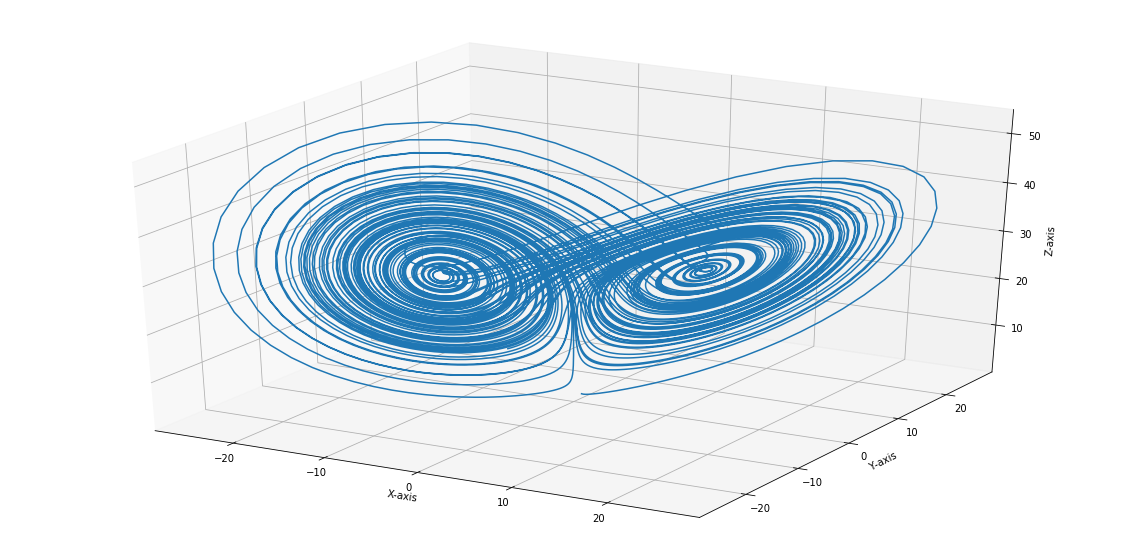

In [39]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(pred[:,0].detach().numpy(), pred[:,1].detach().numpy(), pred[:,2].detach().numpy())
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [59]:
#small modification
sigma = 9.99999999999
rho = 28
beta = 2.67

dt = 0.01

A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])*dt
Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])*dt
Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])*dt

B = np.array([Q0, Q1, Q2])

I = np.eye(3)
AA = (I+dt*A)


sol = [[ 0., 1., 1.05]]

for i in range(10000):
    x = np.asarray(sol[-1])
    Ax = AA.dot(x)
    
    phix = x.T.dot(B).dot(x)
    
    f = Ax + phix
    sol.append(f)
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)

print('train_x.shape:', train_x.shape)#train_input
print('train_y.shape:', train_y.shape)#train_output

train_x.shape: torch.Size([10000, 3])
train_y.shape: torch.Size([10000, 3])


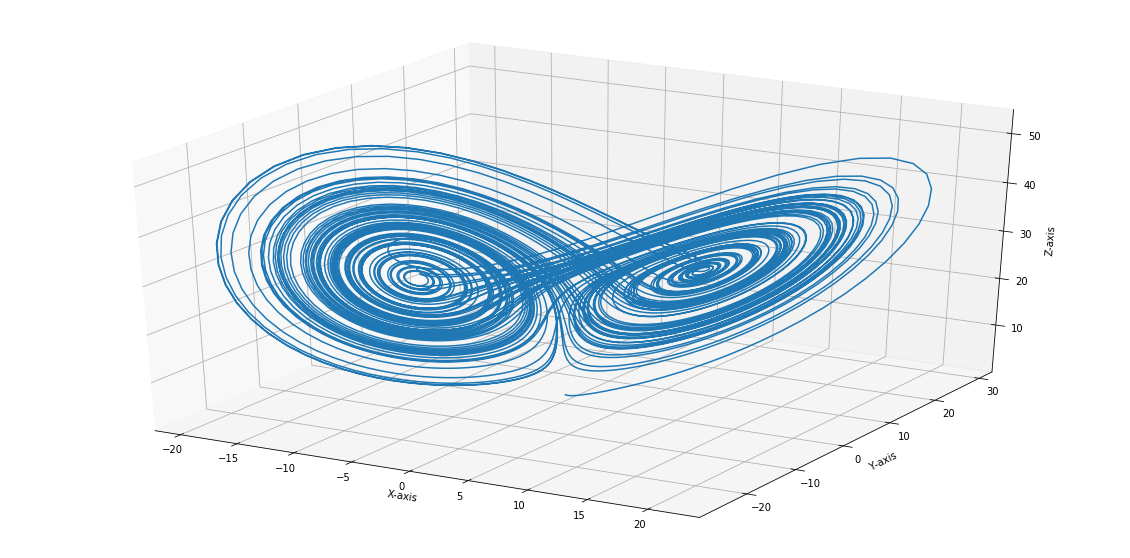

In [60]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2])
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [61]:
train_x

tensor([[  0.0000,   1.0000,   1.0500],
        [  0.1000,   0.9900,   1.0220],
        [  0.1890,   1.0071,   0.9957],
        ...,
        [ -8.8692, -10.0461,  26.2314],
        [ -8.9869, -10.1025,  26.4221],
        [ -9.0985, -10.1433,  26.6245]])

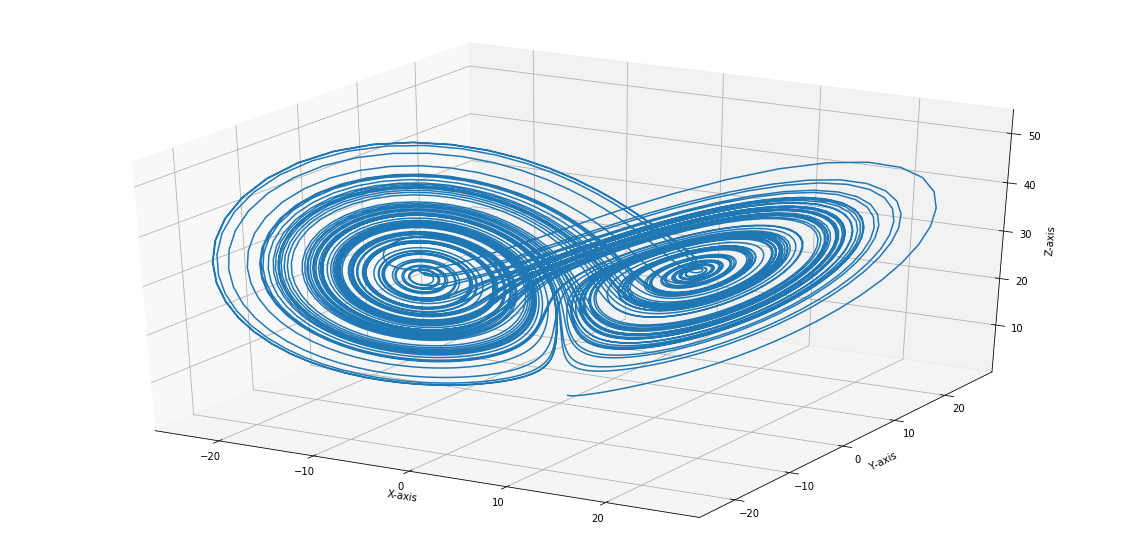

In [62]:
pred2 = model(train_x)
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(pred2[:,0].detach().numpy(), pred2[:,1].detach().numpy(), pred2[:,2].detach().numpy())
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [63]:
(pred2 - pred).pow(2).sum()

tensor(3216428.5000, grad_fn=<SumBackward0>)

In [91]:
#Pytorch test
Q0 = np.asarray([[0.,0.,0.], [0.,0.,0.], [0.,0.,0.]])
Q1 = np.asarray([[0.,0.,-1.], [0.,0.,0.], [0.,0.,0.]])
Q2 = np.asarray([[0.,1.,0.],[0.,0.,0.], [0.,0.,0.]])
sol = [[ 1., 1., 1.05]]

for i in range(10000):
    x = np.asarray(sol[-1])
    
    q0 = x.T.dot(Q0.dot(x))
    q1 = x.T.dot(Q1.dot(x))
    q2 = x.T.dot(Q2.dot(x))

    phix = np.asarray([q0, q1, q2])

    sol.append(phix)
    
X = np.asarray(sol)[:-1]
Y = np.asarray(sol)[1:]
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y)


In [76]:
B = np.array([Q0, Q1, Q2])

In [77]:
B

array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0., -1.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  1.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]])

In [97]:
x = np.array([1.,2.,3.])

In [79]:
x.dot(B.dot(x))

array([0., 0., 0.])

In [81]:
Bx = B.dot(x)

In [83]:
x.T.dot(Bx)

array([0., 0., 0.])

In [85]:
x.dot(B).dot(x)

array([ 0., -3.,  2.])

In [170]:
Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])
Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])
Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])

B = torch.Tensor([Q0, Q1, Q2]).requires_grad_(True)

In [182]:
B

tensor([[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0., -1.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  1.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]], requires_grad=True)

In [207]:
y = np.arange(6).reshape(2,3)
x = torch.Tensor(y)
y

array([[0, 1, 2],
       [3, 4, 5]])

In [97]:
x[0].shape

torch.Size([3])

In [185]:
phi = torch.diagonal(x.mm(B[0]).mm(x.t())).view(x.size(0), 1)
print(phi)
for dim in range(1, x.size(1)):
    q = torch.diagonal(x.mm(B[dim]).mm(x.t())).view(x.size(0), 1)
    print(q)
    phi = torch.cat((phi, q), dim=1)
    print(phi)
    

tensor([[0.],
        [0.]], grad_fn=<ViewBackward>)
tensor([[  0.],
        [-15.]], grad_fn=<ViewBackward>)
tensor([[  0.,   0.],
        [  0., -15.]], grad_fn=<CatBackward>)
tensor([[ 0.],
        [12.]], grad_fn=<ViewBackward>)
tensor([[  0.,   0.,   0.],
        [  0., -15.,  12.]], grad_fn=<CatBackward>)


In [186]:
phi = torch.diagonal(x.matmul(B[0]).matmul(x.t())).view(x.size(0), 1)
print(phi)
for dim in range(1, x.size(1)):
    q = torch.diagonal(x.matmul(B[dim]).matmul(x.t())).view(x.size(0), 1)
    print(q)
    phi = torch.cat((phi, q), dim=1)
    print(phi)
    

tensor([[0.],
        [0.]], grad_fn=<ViewBackward>)
tensor([[  0.],
        [-15.]], grad_fn=<ViewBackward>)
tensor([[  0.,   0.],
        [  0., -15.]], grad_fn=<CatBackward>)
tensor([[ 0.],
        [12.]], grad_fn=<ViewBackward>)
tensor([[  0.,   0.,   0.],
        [  0., -15.,  12.]], grad_fn=<CatBackward>)


In [200]:
xBx = x.matmul(B).matmul(x.t())
xBx.permute(2,1,0)

tensor([[[  0.,   0.,   0.],
         [  0.,  -6.,   3.]],

        [[  0.,   0.,   0.],
         [  0., -15.,  12.]]], grad_fn=<PermuteBackward>)

In [181]:
x.mm(torch.Tensor(AA).requires_grad_(True))

tensor([[0.2800, 0.9900, 1.9467],
        [3.8200, 4.2600, 4.8667]], grad_fn=<MmBackward>)

In [187]:
x.matmul(torch.Tensor(AA).requires_grad_(True))

tensor([[0.2800, 0.9900, 1.9467],
        [3.8200, 4.2600, 4.8667]], grad_fn=<MmBackward>)

In [202]:
xBxd = torch.diagonal(xBx.permute(2,1,0)).t()
xBxd

tensor([[  0.,   0.,   0.],
        [  0., -15.,  12.]], grad_fn=<TBackward>)

In [115]:
t = 1
x = x[t].view(1,3)
phi = x.matmul(B[0]).matmul(x.t())
for dim in range(1, x.size(1)):
    q = x.matmul(B[dim]).matmul(x.t())
    phi = torch.cat((phi, q), dim=1)
    
phi

tensor([[  0., -15.,  12.]])

In [73]:
x = np.arange(6).reshape(2,3)
x = torch.Tensor(x)

In [78]:
x.size(0)

2

In [9]:
xBx = x.matmul(B).matmul(x.t())

In [205]:
B = np.asarray([Q0, Q1, Q2])
B

array([[[ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  , -0.01],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  ]]])

In [219]:
yBy = y.dot(B).dot(y.T)
yBy.transpose(2,0,1)

array([[[ 0.  ,  0.  ,  0.  ],
        [ 0.  , -0.06,  0.03]],

       [[ 0.  ,  0.  ,  0.  ],
        [ 0.  , -0.15,  0.12]]])

In [221]:
np.diagonal(yBy.transpose(2,0,1)).transpose()

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  , -0.15,  0.12]])

In [233]:
y = np.array([1.,2.,3.])
y

array([1., 2., 3.])

In [234]:
y.T.dot(B).dot(y)

array([ 0.  , -0.03,  0.02])